###  В этой задаче по историческим данным о погодных условиях и аренде велосипедов требуется предсказать, сколько же велосипедов будет занято в заданный день и час. В исходной постановке задачи нам доступно 11 признаков, среди них есть как числовые признаки, так и категориальные, и бинарные данные.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn import model_selection, linear_model, metrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
%matplotlib inline

### Загрузка данных

In [5]:
data = pd.read_csv("D:\DATA\datalake.csv")

In [6]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### 
datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [7]:
data.shape

(10886, 12)

In [8]:
pd.isnull(data).any()

datetime      False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
dtype: bool

### Предобработка данных

##### типы данных

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [10]:
#В колонке datatime изменим тип данных на datatime,
#так как он будет более предпочтителен,
#так как к нему теперь можно будет применять специфичные операции

data.datetime = data.datetime.apply(pd.to_datetime)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [12]:
#Добавим колонки месяц и час

data['month'] = data.datetime.apply(lambda x : x.month)
data['hour'] = data.datetime.apply(lambda x : x.hour)

In [13]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


##### Обучение и отложенный тест

In [14]:
#Так как наши данные имеют строгую привязку по времени, то для их разбиения просто "отрежем" последнюю 1000 данных
#Разделяя выборку случайно, можно сильно переобучиться, ведь при настоящем использовании у нас таких данных не будет.

train_data = data.iloc[:-1000, :]
test_data = data.iloc[-1000:, :]

In [15]:
print(data.shape, train_data.shape, test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [16]:
print(f'train period from {train_data.datetime.min()} to {train_data.datetime.max()}')
print(f'evaluation period from {test_data.datetime.min()} to {test_data.datetime.max()}')

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
evaluation period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


##### данные и целевая функция

In [17]:
#Целевая метка находится в столбце count - вырежем её
#Также вырежем datatime, т.к. фактически это просто идентификатор объекта

In [18]:
#обучение

train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count'], axis = 1)

In [19]:
#тест

test_labels = test_data['count'].values
test_data = test_data.drop(['datetime', 'count'], axis = 1)

Text(0.5, 1.0, 'test data')

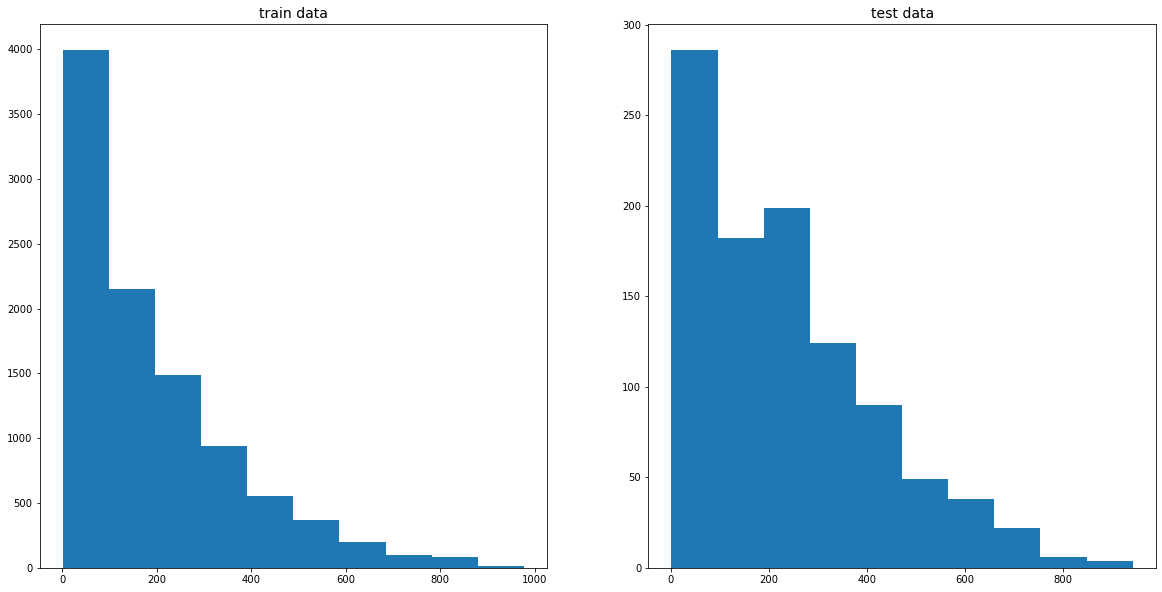

In [20]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.hist(train_labels)
plt.title("train data", fontsize = 14)

plt.subplot(1, 2, 2)
plt.hist(test_labels)
plt.title("test data", fontsize = 14)

##### числовые признаки

In [21]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [22]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [23]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [24]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


### Модель

In [25]:
#Будем использовать SGDRegressor - это линейная регрессия со стохастическим градиентным спуском
#Особенно полезна при большом объёме данных

In [26]:
regressor = linear_model.SGDRegressor(random_state = 0)
regressor.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [27]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

32678333066101.652

In [28]:
#Ошибка получилась невероятно большой
#Посмотрим на предсказания и сравним их
#С правильным значением целевой функции

In [29]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [30]:
print(regressor.predict(test_data)[:10])

[-8.15217468e+13 -1.27940348e+14 -5.15430820e+13 -2.29149119e+13
 -2.58255957e+13 -3.85635403e+13 -3.92648763e+13 -3.03104198e+13
 -4.03846575e+13 -5.57515848e+13]


In [31]:
regressor.coef_

array([-2.30285477e+10, -5.87204402e+08, -1.27291755e+10, -1.27359409e+09,
        5.83730183e+10, -1.60478942e+11, -3.67459548e+10, -4.87006373e+09])

In [32]:
#Такие большие коэффициент получились, возможно, из-за
#Того, что признаки не масштабированы 

### Масштабирование

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
#Создаем стандартный scaler

scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [35]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.042930483012407816

In [36]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [37]:
print(regressor.predict(scaled_test_data)[:10])

[524.90958201 834.88816062 354.94091402 221.96933203 227.95283001
 324.96044934 327.966113   307.98463956 345.96942383 445.96231877]


In [38]:
#Масштабирование помогло

### Проверим, всё ли хорошо с нашей моделью

In [39]:
print(regressor.coef_)

[ 4.58902678e-01 -4.51836158e-01  6.62608792e-04 -1.40703258e-02
  5.08590377e+01  1.48008168e+02 -1.32281341e-03  7.59230341e-03]


In [40]:
print(list(map(lambda x : round(x, 2), regressor.coef_)))

[0.46, -0.45, 0.0, -0.01, 50.86, 148.01, -0.0, 0.01]


In [41]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [42]:
#casual и regirstred сильно выделяются и по сути задают нашу целевую функцию
#Проверим это предположение и если это так, то удалим их

In [43]:
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14], dtype=int64)

In [44]:
np.all(train_data.registered + train_data.casual == train_labels)

True

In [45]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
test_data.drop(['casual', 'registered'], axis = 1, inplace = True)

In [46]:
train_data.head()

,temp,atemp,humidity,windspeed,month,hour
0,9.84,14.395,81,0.0,1,0
1,9.02,13.635,80,0.0,1,1
2,9.02,13.635,80,0.0,1,2
3,9.84,14.395,75,0.0,1,3
4,9.84,14.395,75,0.0,1,4


In [47]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [48]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

121.8835371361759

In [49]:
print(list(map(lambda x : round(x, 2), regressor.coef_)))

[30.01, 32.15, -42.28, 3.78, 12.71, 50.06]


In [50]:
#В среднем ошибка на 122 велосипеда
#Попытаемся улучшить модель подбором параметров с помощью кросс-валидации

### Pipeline

In [51]:
from sklearn.pipeline import Pipeline

In [52]:
#создаем pipeline из двух шагов: scaling и классификация

pipeline = Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

In [53]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

121.8835371361759

In [54]:
#Ошибка не изменилась, следовательно, 
#Всё сделали правильно и цепочка готова

### Подбор параметров

In [55]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__early_stopping', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter_no_change', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__validation_fraction', 'regression__verbose', 'regression__warm_start'])

In [56]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [57]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [58]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 10.8 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('regression',
                                        SGDRegressor(random_state=0))]),
             param_grid={'regression__alpha': [0.0001, 0.01],
                         'regression__loss': ['huber', 'epsilon_insensitive',
                                              'squared_loss'],
                         'regression__max_iter': [3, 5, 10, 50],
                         'regression__penalty': ['l1', 'l2', 'none'],
                         'scaling__with_mean': [0.0, 0.5]},
             scoring='neg_mean_absolute_error')

In [59]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-108.61772632999148
{'regression__alpha': 0.01, 'regression__loss': 'squared_loss', 'regression__max_iter': 3, 'regression__penalty': 'l2', 'scaling__with_mean': 0.0}


### Оценка по отложенному тесту

In [60]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

119.98978845935378

In [61]:
np.mean(test_labels)

232.159

##### Фактически оптимизация с помощью подбора параметров не помогла улучшить модель

In [62]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [63]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [64]:
print(test_predictions[:10])

[139.60470681 159.80765341 207.55935972 237.76288054 257.83836668
 267.44558034 272.49537469 297.70688522 304.29818873 313.58821156]


(-100.0, 1100.0)

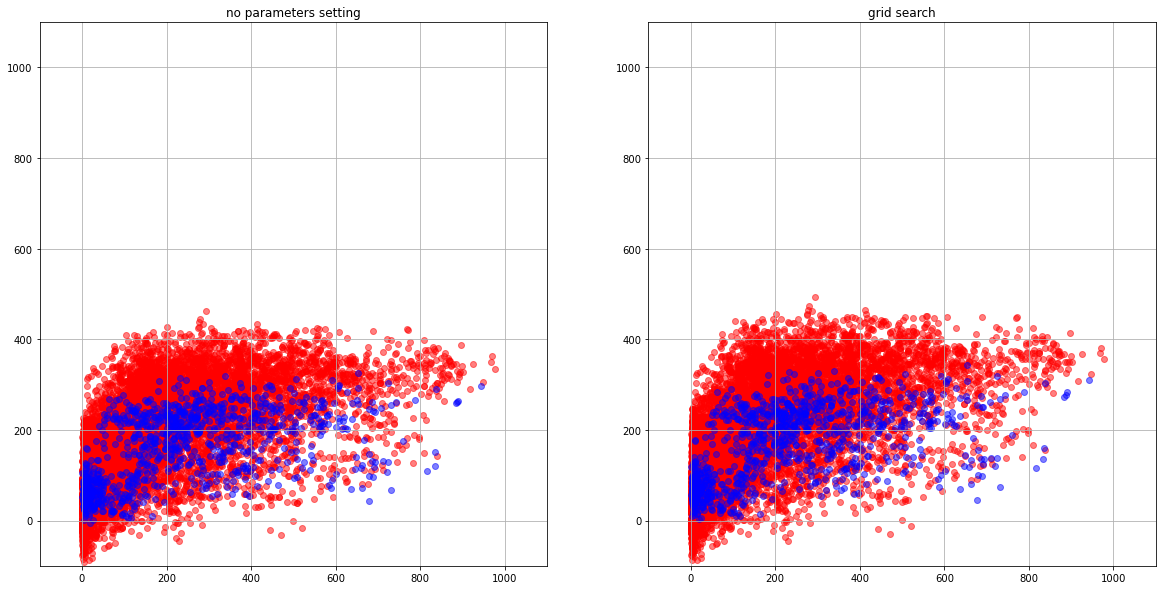

In [65]:
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color = 'blue')
plt.title('no parameters setting')
plt.xlim(-100,1100)
plt.ylim(-100,1100)

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.title('grid search')
plt.xlim(-100,1100)
plt.ylim(-100,1100)

### Попробуем добавить все остальные признаки

In [66]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


### Предобработка данных

##### Обучение и отложенный тест

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  month       10886 non-null  int64         
 13  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(10)
memory usage: 1.2 MB


In [69]:
train_data = data.iloc[:-1000, :]
hold_out_test_data = data.iloc[-1000:, :]

In [71]:
print(data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [72]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [73]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [74]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [98]:
train_data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour
0,1,0,0,1,9.84,14.395,81,0.0000,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,1,4
...,...,...,...,...,...,...,...,...,...,...
9881,4,0,1,1,18.04,21.970,67,8.9981,10,2
9882,4,0,1,1,17.22,21.210,67,7.0015,10,3
9883,4,0,1,1,17.22,21.210,67,11.0014,10,4
9884,4,0,1,1,17.22,21.210,67,16.9979,10,5


In [75]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [76]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [77]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [79]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [80]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [82]:
regressor = linear_model.SGDRegressor(random_state = 0, max_iter = 3, loss = 'squared_loss', penalty = 'l2')

In [86]:
from sklearn import pipeline, preprocessing

In [103]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [104]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x0000029E10917310>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000029E10917CA0>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000029E109

In [105]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.17177172806856

### Подбор параметров

In [106]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__verbose', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__check_inverse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__verbose'

In [107]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [108]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [109]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 743 ms


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000029E10917310>)),
                                                                       ('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000029E10917CA0>)),
                                                                                        ('scaling',
                                                                                         StandardScaler(wit...
                                                                       ('categorical_variables_pro

In [110]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-106.60524061317197
{'model_fitting__alpha': 0.001, 'model_fitting__eta0': 0.05}


### Оценка по отложенному тесту

In [111]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [112]:
metrics.mean_absolute_error(test_labels, test_predictions)

125.11055616822885

In [113]:
print(test_labels[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [118]:
print(np.round(test_predictions[:20], 2))

[153.29 181.9  227.64 262.48 278.91 279.82 301.62 333.35 336.28 348.55
 346.29 336.77 318.3  298.65 285.36 246.03 252.72  58.97  66.44  73.91]


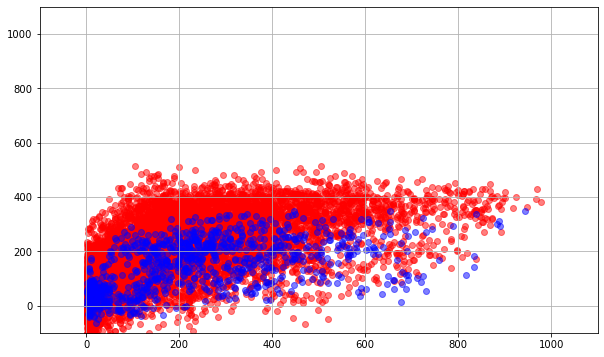

In [121]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

### Другая модель

In [122]:
from sklearn.ensemble import RandomForestRegressor

In [123]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [126]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.loc[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [127]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x0000029E105425E0>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000029E10542790>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0,
                                                                                 with_std=1))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                 

In [128]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.49758619912876

In [131]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [132]:
print(np.round(estimator.predict(test_data)[:10], 2))

[409.56 505.56 256.06 165.65 205.82 265.92 254.62 317.86 280.99 434.51]


Text(0.5, 1.0, 'random forest model')

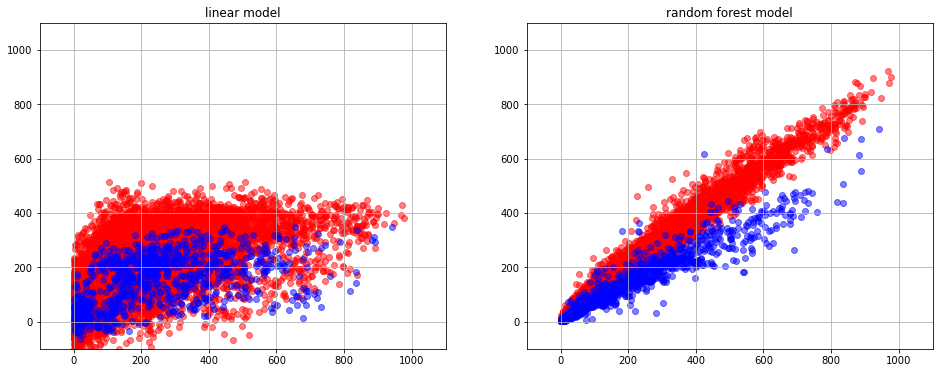

In [133]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.title('linear model')

plt.subplot(1,2,2)
plt.grid(True)
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
plt.title('random forest model')